Setup
==

In [1]:
from scipy.io import arff
import pandas
from sklearn import svm, metrics, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import feature_selection as fs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from math import pow

%matplotlib inline

In [2]:
# load basic feature data
data, meta = arff.loadarff('emobase2010.arff')
df = pandas.DataFrame.from_records(data)
print('#instances x #features(+1) =', df.shape)

# add ids from separate file to dataframe
with open('instances.txt', 'r') as id_file:
    instances = id_file.readlines()
    fids = [instance.split('.')[0] 
            for instance in instances]
    uids = [instance.split('.')[1].replace('\n', '') 
            for instance in instances]
    df['fid'] = fids
    df['uid'] = uids
cols = list(data.dtype.names)
cols.append('fid')
cols.append('uid')
df.columns = cols

# load emotion ratings
with open('eval/intensity.txt', 'r') as csv_file:
    df2 = pandas.read_csv(csv_file, dtype={'uid':'str'})

# compute mean intensity rating for each instance...
df2['mean'] = df2[['EF01','EF02','EF03','EF04','EF06',
                   'EM01','EM02','EM03','EM04','EM05',
                   'EM06','EM07','EM08','EM09','EM11',
                   'EM12','EM14','EM15']].mean(axis=1)
# ...and drop individual ratings
df2 = df2.drop(['EF01','EF02','EF03','EF04','EF06',
                'EM01','EM02','EM03','EM04','EM05',
                'EM06','EM07','EM08','EM09','EM11',
                'EM12','EM14','EM15'], axis=1)

# merge features with emotion ratings (inner join)
# (different order -> need to use merge)
df = pandas.merge(df, df2, on=['fid', 'uid'])

#instances x #features(+1) = (4850, 1583)


In [3]:
# remove instances with 'neutral', 'unknown' and 'other' label
a = df['emotion']!='NEU'
b = df['emotion']!='UNK'
c = df['emotion']!='OTH'
df = df.loc[a&b&c]

# number of instances per class
print(df['emotion'].value_counts())

# total number of remaining instances
print('sum:', len(df))

SUR    386
DIS    223
JOY    215
ANT    191
SAD    170
ACC    164
ANG    146
FEA     87
Name: emotion, dtype: int64
sum: 1582


In [4]:
df

,pcm_loudness_sma_maxPos,pcm_loudness_sma_minPos,pcm_loudness_sma_amean,pcm_loudness_sma_linregc1,pcm_loudness_sma_linregc2,pcm_loudness_sma_linregerrA,pcm_loudness_sma_linregerrQ,pcm_loudness_sma_stddev,pcm_loudness_sma_skewness,pcm_loudness_sma_kurtosis,...,shimmerLocal_sma_de_percentile99.0,shimmerLocal_sma_de_upleveltime75,shimmerLocal_sma_de_upleveltime90,F0final__Turn_numOnsets,F0final__Turn_duration,class,fid,uid,emotion,mean
0,0.290909,0.000000,0.258640,0.000719,0.239240,0.078132,0.008620,0.093542,-0.021157,2.429211,...,0.030707,0.072727,0.018182,1.0,0.57,b'ACC',01_MMK_2,013,SUR,2.166667
1,0.533333,0.883333,0.151027,-0.002178,0.215283,0.116132,0.019550,0.144819,0.891886,2.575608,...,0.206826,0.125000,0.050000,3.0,0.62,b'ACC',05_MYH,017,ACC,2.333333
2,0.132076,0.000000,0.298068,0.000008,0.297868,0.096203,0.013251,0.115113,0.004746,2.158694,...,0.185000,0.065217,0.043478,3.0,0.55,b'FEA',01_MAD_1,396,JOY,2.055556
3,0.785714,0.000000,0.082860,0.003008,0.063309,0.017077,0.000420,0.023817,-0.266671,2.478187,...,0.000000,0.000000,0.000000,0.0,0.16,b'SUR',01_MMK_1,430,SUR,1.888889
4,0.592593,0.407407,0.079869,0.001050,0.066220,0.028754,0.001185,0.035386,-0.056963,1.861217,...,0.000000,0.000000,0.000000,0.0,0.29,b'SAD',01_MMK_1,397,SAD,3.111111
5,0.764706,0.000000,0.409581,0.016374,0.278593,0.115249,0.019151,0.159953,0.224859,2.499954,...,0.157520,0.200000,0.066667,3.0,0.19,b'ANG',01_MAD_1,081,ANG,2.444444
6,0.823529,0.000000,0.176277,0.011218,0.086531,0.045721,0.002712,0.075714,0.269838,2.357958,...,0.026929,0.266667,0.066667,1.0,0.19,b'SUR',04_MNN,703,SUR,1.777778
7,0.117647,0.858823,0.336360,-0.004572,0.528398,0.159192,0.036350,0.221215,0.911612,4.025831,...,0.195774,0.109589,0.041096,6.0,0.87,b'ANT',02_MTN,042,ANT,3.166667
8,0.204698,0.412752,0.147276,-0.000276,0.188270,0.090380,0.013479,0.118502,1.222397,4.326225,...,0.182839,0.025907,0.010363,11.0,3.00,b'ANT',01_MAD_1,569,ANT,2.722222
9,0.631206,0.978723,0.233684,0.000608,0.191119,0.140190,0.028470,0.170537,0.779474,3.093070,...,0.137699,0.088235,0.049020,8.0,1.43,b'ANT',01_MMK_1,109,JOY,2.500000


Experiment 1: Regression per emotion
==

For each emotion label (as given by instances.txt), run a regression on the average intensity rating. Find a "best" configuration first, by trying different feature selections on a train set and use this configuration to predict on a test set.

In [5]:
labels = ['SUR', 'DIS', 'ANT', 'ACC', 'JOY', 'SAD', 'ANG', 'FEA']
best = {}
for label in labels:
    # get features and labels, split into dataframe
    best[label] = [float('inf')]
    df_sub = df.loc[df['emotion'] == label]
    df_sub = df_sub.drop(['class', 'fid', 'uid', 'emotion'], axis=1)
    df_train, df_test = np.array_split(df_sub, [int(len(df_sub) * 0.8)])
    features, labels = np.split(df_train.as_matrix(), [-1], axis=1)
    labels = [label[0] for label in labels]
    std = np.std(labels)
    np.seterr(divide='ignore', invalid='ignore')
    
    # try feature counts and selection methods on train to find "best"
    for k in ['all'] + [int(len(df_train) / d) 
                        for d in [pow(2, i) for i in range(-2, 6)]]:
        for reg in [fs.f_regression, fs.mutual_info_regression]:
            sel = fs.SelectKBest(reg, k=k).fit(features, labels)
            # this shows which features were selected:
            # df_train.axes[1][:-1][sel.get_support()]
            features_new = sel.transform(features)
            mod = linear_model.LinearRegression(n_jobs=-1)
            predicted = cross_val_predict(mod, features_new, 
                                          labels, n_jobs=-1)
            mse = metrics.mean_squared_error(labels, predicted)
            mae = metrics.mean_absolute_error(labels, predicted)
            if mse < best[label][0]:
                best[label] = [mse, mae, std, reg, k]
    
    # train with "best" config and predict on test
    sel = fs.SelectKBest(best[label][3], k=best[label][4]
                     ).fit(features, labels)
    features_new = sel.transform(features)
    mod = linear_model.LinearRegression(n_jobs=-1
                                       ).fit(features_new, labels)
    features_test, labels_test = np.split(df_test.as_matrix(), 
                                          [-1], axis=1)
    features_test_new = sel.transform(features_test)
    predicted = mod.predict(features_test_new)
    mse = metrics.mean_squared_error(labels_test, predicted)
    mae = metrics.mean_absolute_error(labels_test, predicted)
    mean = sum(labels) / len(labels)
    predicted_bl = [mean for label in labels_test]
    mse_bl = metrics.mean_squared_error(labels_test, predicted_bl)
    mae_bl = metrics.mean_absolute_error(labels_test, predicted_bl)
    best[label].extend([mse, mae, np.std(labels_test), len(df_train),
                        mse_bl, mae_bl])


In [6]:
pandas.DataFrame(
    {
     'a) label':
         [key for key, val in best.items()],
     'b) feature selection function':
         [str(val[3]).split()[1] for key, val in best.items()],
     'c) #features':
         [val[4] for key, val in best.items()],
     'd) mse':
         [val[5] for key, val in best.items()],
     'e) mse (bl)':
         [val[9] for key, val in best.items()],
     'f) mae':
         [val[6] for key, val in best.items()],
     'g) mae (bl)':
         [val[10] for key, val in best.items()],
     'h) std on test':
         [val[7] for key, val in best.items()],
     'i) training size':
         [val[8] for key, val in best.items()],
    })

,a) label,b) feature selection function,c) #features,d) mse,e) mse (bl),f) mae,g) mae (bl),h) std on test,i) training size
0,ANG,f_regression,3,0.166417,0.140072,0.329819,0.302490,0.364062,116
1,FEA,f_regression,2,0.160192,0.133973,0.296046,0.295357,0.364420,69
2,JOY,mutual_info_regression,10,0.239744,0.304603,0.401909,0.445571,0.521202,172
3,ACC,mutual_info_regression,4,0.116489,0.163575,0.290901,0.346082,0.402424,131
4,SAD,mutual_info_regression,4,0.191111,0.205810,0.374664,0.395233,0.433426,136
5,DIS,f_regression,5,0.248469,0.205426,0.392227,0.359169,0.451714,178
6,ANT,f_regression,4,0.156105,0.196865,0.301512,0.349237,0.435063,152
7,SUR,mutual_info_regression,38,0.234912,0.470990,0.346335,0.516507,0.686273,308


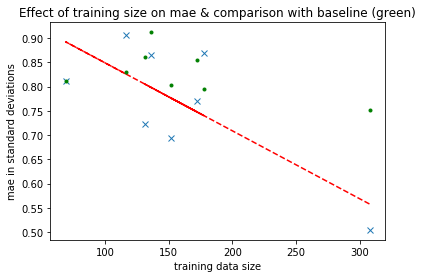

In [7]:
x = [val[8] for key, val in best.items()]
y = [val[6] / val[7] for key, val in best.items()]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
bl = [val[10] / val[7] for key, val in best.items()]
plt.plot(x, y, 'x', x, p(x), 'r--', x, bl, 'g.')
plt.xlabel('training data size')
plt.ylabel('mae in standard deviations')
plt.title('Effect of training size on mae & comparison with baseline (green)')
plt.grid(False)
plt.show()

Discussion
==

The experiment does not reveal a clear preference for either feature selection method, with each being found to perform better than the other four times. This could mean that the data mostly contains linear dependencies between features, which both methods can detect, and not more complex dependencies, which only the mutual information method can detect. Alternatively, it could be that the amount of data for most emotions is not large enough for the mutual information method to work effectively. Perhaps that is why for SUR, with the largest training set, a much greater number of features was selected (using mutual information) and a large improvement over the baseline (mean rating observed during training) was achieved. That is, perhaps only for this emotion was there enough data to detect more than linear dependencies, allowing for a better selection of features besides obviously providing more data to learn from.

As expected, there is a clear tendency for a larger training set to yield a lower mean absolute error (normalized by standard deviation of ratings per emotion). For most of the emotions an improvement over the baseline was achieved. However, for ANG and DIS there was a notable decrease in the prediction quality over the baseline, of similar magnitude as the improvements for the emotions of comparable training size. This might mean that training sizes below 200 are too small and the improvements there are not significant, whereas the improvement for SUR certainly seems significant. I did not perform any analysis of significance to verify this, though.

In conclusion, with "enough" data it is possible to predict emotion intensity ratings from the given features within as little as 0.5 standard deviations, a notable improvement over the baseline. Smaller amounts of data seem insufficient to improve on the baseline with the methods tested here.

Experiment 2: Regression over all emotions
==

Run regression on the mean intensity rating for all emotions at once. Find a "best" feature selection configuration on a train set first, then use this to predict on a test set.

The code is largely the same as for experiment 1.

In [8]:
# get features and labels, split into dataframe
df_cp = df
df_cp = df.drop(['class', 'fid', 'uid', 'emotion'], axis=1)
df_train, df_test = np.array_split(df_cp, [int(len(df_cp) * 0.8)])
features, labels = np.split(df_train.as_matrix(), [-1], axis=1)
labels = [label[0] for label in labels]
std = np.std(labels)
np.seterr(divide='ignore', invalid='ignore')

# try feature counts and selection methods on train to find "best"
best = [float('inf')]
for k in [int(len(df_train) / d) 
          for d in [pow(2, i) for i in range(0, 11)]]:
    for reg in [fs.f_regression, fs.mutual_info_regression]:
        sel = fs.SelectKBest(reg, k=k).fit(features, labels)
        # this shows which features were selected:
        # df_train.axes[1][:-1][sel.get_support()]
        features_new = sel.transform(features)
        mod = linear_model.LinearRegression(n_jobs=-1)
        predicted = cross_val_predict(mod, features_new, 
                                      labels, n_jobs=-1)
        mse = metrics.mean_squared_error(labels, predicted)
        mae = metrics.mean_absolute_error(labels, predicted)
        if mse < best[0]:
            best = [mse, mae, std, reg, k]

# train with "best" config and predict on test
sel = fs.SelectKBest(best[3], k=best[4]).fit(features, labels)
features_new = sel.transform(features)
mod = linear_model.LinearRegression(n_jobs=-1
                                   ).fit(features_new, labels)
features_test, labels_test = np.split(df_test.as_matrix(), 
                                      [-1], axis=1)
features_test_new = sel.transform(features_test)
predicted = mod.predict(features_test_new)
mse = metrics.mean_squared_error(labels_test, predicted)
mae = metrics.mean_absolute_error(labels_test, predicted)
mean = sum(labels) / len(labels)
predicted_bl = [mean for label in labels_test]
mse_bl = metrics.mean_squared_error(labels_test, predicted_bl)
mae_bl = metrics.mean_absolute_error(labels_test, predicted_bl)

best.extend([mse, mae, np.std(labels_test), len(df_train), mse_bl, mae_bl])
print(best)

[0.22148241238425265, 0.3775465314949496, 0.53665305986651179, <function mutual_info_regression at 0x7fddc4b4cbf8>, 9, 0.2141868544412846, 0.36618936078105419, 0.54022814726838286, 1265, 0.29475775689070416, 0.4236895078892064]


Discussion
==

Prediction of intensity for all emotions at once was not very successful. With 0.68 standard deviations mean absolute error, the improvement over the baseline of 0.78 is not very large, and the result is comparable to those achieved for much smaller training sizes for individual emotions. Thus, it appears that intensity is expressed differently across emotions and the model was not able to capture that fully with the training data given.

Suprisingly, selection of only 9 features yielded the best results in cross-validation on the training set. One might have expected a larger number to perform better. A training size of 1265 should be enough to make use of 18 features, at least, which would have been the next higher number the algorithm attempted. I cannot think of a good explanation for this. 

Experiment 3: Classification with training on "high intensity" instances
==

Train a classifier only on instances with a "high" rating for "intensity". Try different thresholds and for each one find a "best" configuration for feature selection on a train set, then evaluate on a dev set (including low intensity instances). Use the "best" threshold and its "best" feature selection configuration to learn on the train set and predict the test set (including low intensity instances).

The idea here is that training only on "high" intensity instances might allow the model to better pick up on stereotypical characteristics of each emotional expression, making for a clearer distinction between the emotions.

In [10]:
df_cp = df.drop(['class', 'fid', 'uid'], axis=1)
df_train, df_dev, df_test = np.array_split(
    df_cp, [int(len(df_cp) * 0.6), int(len(df_cp) * 0.8)])

best = {}
best['all'] = [float('-inf')]

for thresh in [0.0] + [i/10.0 for i in range(18, 31)]:
    # reduce train set to instances above threshold
    hi = df_train['mean'] > thresh
    df_train_new = df_train.loc[hi]
    df_train_new = df_train_new.drop('mean', axis=1)
    features, labels = np.split(
        df_train_new.as_matrix(), [-1], axis=1)
    labels = [label[0] for label in labels]
    np.seterr(divide='ignore', invalid='ignore')
    
    # try feature counts and selection methods on train to find "best"
    # configuration for this thresh
    best[thresh] = [float('-inf')]
    for k in [int(len(df_train_new) / d) 
              for d in [pow(2, i) for i in range(1, 8)]]:
        for reg in [fs.f_classif
                   ,fs.mutual_info_classif
                   ]:
            sel = fs.SelectKBest(reg, k=k).fit(features, labels)
            # this shows which features were selected:
            # df_train.axes[1][:-1][sel.get_support()]
            features_new = sel.transform(features)
            wclf = svm.SVC(kernel='linear', class_weight='balanced')
            predicted = cross_val_predict(wclf, features_new, 
                                          labels, n_jobs=-1)
            acc = metrics.accuracy_score(labels, predicted)
            # print(k, reg, acc)
            if acc > best[thresh][0]:
                best[thresh] = [acc, reg, k]

    # train with "best" config for this thresh and predict on dev
    sel = fs.SelectKBest(best[thresh][1], k=best[thresh][2]
                        ).fit(features, labels)
    features_new = sel.transform(features)
    wclf = svm.SVC(kernel='linear', class_weight='balanced'
                  ).fit(features_new, labels)
    df_dev_new = df_dev.drop('mean', axis=1)
    features_dev, labels_dev = np.split(df_dev_new.as_matrix(), 
                                        [-1], axis=1)
    features_dev_new = sel.transform(features_dev)
    predicted = wclf.predict(features_dev_new)
    acc = metrics.accuracy_score(labels_dev, predicted)
    best[thresh].extend([acc])
    print([thresh] + best[thresh])
    if acc > best['all'][0]:
        best['all'] = [thresh] + best[thresh]


[0.0, 0.34035827186512119, <function mutual_info_classif at 0x7fd7b392ac80>, 29, 0.33544303797468356]
[1.8, 0.34159482758620691, <function mutual_info_classif at 0x7fd7b392ac80>, 232, 0.31329113924050633]
[1.9, 0.3493975903614458, <function mutual_info_classif at 0x7fd7b392ac80>, 28, 0.33860759493670883]
[2.0, 0.35083798882681566, <function mutual_info_classif at 0x7fd7b392ac80>, 55, 0.30379746835443039]
[2.1, 0.35487528344671204, <function mutual_info_classif at 0x7fd7b392ac80>, 27, 0.33860759493670883]
[2.2, 0.35112692763938314, <function f_classif at 0x7fd7b498d6a8>, 52, 0.32911392405063289]
[2.3, 0.35308953341740229, <function mutual_info_classif at 0x7fd7b392ac80>, 24, 0.32911392405063289]
[2.4, 0.35753424657534244, <function mutual_info_classif at 0x7fd7b392ac80>, 365, 0.27848101265822783]


/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: 

[2.5, 0.34550989345509892, <function f_classif at 0x7fd7b498d6a8>, 20, 0.27848101265822783]


/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)


[2.6, 0.36142625607779577, <function mutual_info_classif at 0x7fd7b392ac80>, 308, 0.28797468354430378]


/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: 

[2.7, 0.35873605947955389, <function mutual_info_classif at 0x7fd7b392ac80>, 269, 0.24367088607594936]


/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: 

[2.8, 0.35714285714285715, <function f_classif at 0x7fd7b498d6a8>, 224, 0.26582278481012656]


/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)


[2.9, 0.39361702127659576, <function mutual_info_classif at 0x7fd7b392ac80>, 47, 0.25]


/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [673] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: 

[3.0, 0.37627118644067797, <function mutual_info_classif at 0x7fd7b392ac80>, 73, 0.21518987341772153]


In [11]:
# train with "best" thresh and its "best" config on train 
# and predict on test
df_train_new = df_train
hi = df_train_new['mean'] > best['all'][0]
df_train_new = df_train_new.loc[hi]
df_train_new = df_train_new.drop('mean', axis=1)
features, labels = np.split(df_train_new.as_matrix(), [-1], axis=1)
labels = [label[0] for label in labels]

sel = fs.SelectKBest(best['all'][2], k=best['all'][3]
                    ).fit(features, labels)
features_new = sel.transform(features)
wclf = svm.SVC(kernel='linear', class_weight='balanced'
              ).fit(features_new, labels)

df_test_new = df_test.drop('mean', axis=1)
features_test, labels_test = np.split(df_test_new.as_matrix(), 
                                      [-1], axis=1)
labels_test = [label[0] for label in labels_test]

features_test_new = sel.transform(features_test)
predicted = wclf.predict(features_test_new)
acc = metrics.accuracy_score(labels_test, predicted)
print(acc)

# train with 0.0 thresh and its "best" config on train
# and predict on test
df_train_new = df_train
df_train_new = df_train_new.drop('mean', axis=1)
features, labels = np.split(df_train_new.as_matrix(), [-1], axis=1)
labels = [label[0] for label in labels]

sel = fs.SelectKBest(best[0.0][1], k=best[0.0][2]
                    ).fit(features, labels)
features_new = sel.transform(features)
wclf = svm.SVC(kernel='linear', class_weight='balanced'
              ).fit(features_new, labels)

df_test_new = df_test.drop('mean', axis=1)
features_test, labels_test = np.split(df_test_new.as_matrix(), 
                                      [-1], axis=1)
labels_test = [label[0] for label in labels_test]

features_test_new = sel.transform(features_test)
predicted = wclf.predict(features_test_new)
acc = metrics.accuracy_score(labels_test, predicted)
print(acc)

0.309148264984
0.353312302839


In [12]:
# rough baseline -- majority class
print(max(df_test['emotion'].value_counts())/len(df_test['emotion']), 1/8)

0.271293375394 0.125


Discussion
==

The hypothesis has proven to be false. The model that uses all training instances (intensity threshold of 0.0) outperforms the model using the "best" threshold for intensity by 4.4 percentage points. 
A comparison of the accuracies for different thresholds on the train and dev sets seems to explain this. While accuracy on the train set improves from 0.34 for threshold 0.0 to above 0.39 for threshold 2.9, the accuracy on the dev set for those same thresholds goes down from 0.335 to 0.25, respectively. So while having to classify only high-intensity instances does make classification easier, the model learned from those does not generalize to low intensity instances and achieves poor accuracy for them. 